# Linear Regression and Coulomb's Law

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PhysData/course/blob/main/docs/notebooks/elmag.ipynb)

To participate in the interactive aspects of this notebook, select the 'Open in Colab' option!

If you're running this in Colab, make sure to save a copy of the notebook in Google Drive to save your changes.


**What is Coulomb's Law?**

Coulomb's law, discovered by Charles-Augustin de Coulomb in the late 18th century, states that there is a linear relationship between the force that two charged particles exert on each other and the inverse square of the distance between them. Coulomb's law is described by the equation:

$$ F = k \frac{q_1 q_2}{r^2} $$

where $F$ is the force (N), $q_1$ and $q_2$ are the magnitudes of the charges (C), $r$ is the distance between the charges (m),  $k$ is Coulomb's constant (~8.98 x 10^9 $Nm^2C^{-2}$).

Coulomb used a torsion balance to derive the inverse square proportionality; he charged two spheres with known quantities of static electricity and used the repulsion to twist a fibre, from which he could measure the force between them.



**The aim of the notebook**

In this notebook, we will explore how data science can help us to more rigorously understand physical phenomena by using synthetic data with predefined noise parameters. This can help us test the robustness of our models without needing to collect experimental data as well as be able to better explain the predictions our models make in the real world.


## Simulating Data

Firstly, we will explore how we can use existing libraries to generate synthetic data. This is an easy way to explore how our models behave under uncertainty in our input data. In other words, we can generate synthetic data to model uncertainty that might arise in experiments and build our models in a way that is robust. We can also use this technique to get a better understanding of the laws we are simulating, particularly when exploring well known physical concepts (such as Coulomb's law).

The function `random_y_kx` will generate a tuple of numbers `x` and `y` with stochastic linear dependence of `y` on `x`. We're going to use this to model the force-charge relationship in Coulomb's law (with a constant representing one fixed charge and a fixed distance between charges). We'll generate these samples from two normal distributions: one to create x values, and a second to produe variance in the corresponding y values we will add a standard deviation (noise) parameter to reflect the uncertainty in real world measurements.

In [622]:
# If you're running this notebook, uncomment the code in this cell to install the required packages.
# ! pip install numpy
# ! pip install scikit-learn
# ! pip install matplotlib

In [623]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [624]:
def random_y_kx(mean_x=0, sigma_x=1, mean_noise=0, sigma_noise=1, size=1, k=1, systematic_error=0):
    x = np.random.normal(mean_x, sigma_x, size)
    noise = np.random.normal(mean_noise, sigma_noise, size)
    y = k * x + noise + systematic_error
    return x, y

The function `random_y_kx` creates noisy data based on the relation $y=kx+\eta$ where $\eta$ is a noise parameter.

We can now use this function to generate our first synthetic dataset.

In [625]:
data = []
for i in range(50):
    data.append(random_y_kx(sigma_noise=0.2))
    
x = []
y = []
for i in data:
    x.append(i[0][0])
    y.append(i[1][0])

The above code is a simple loop that calls the `random_y_kx` function and appends the data to a list object so that we can inspect it further.

In [626]:
def plot_xy(x, y, title=None, xlabel=None, ylabel=None):
    plt.plot(x, y, 'o')
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    plt.show()

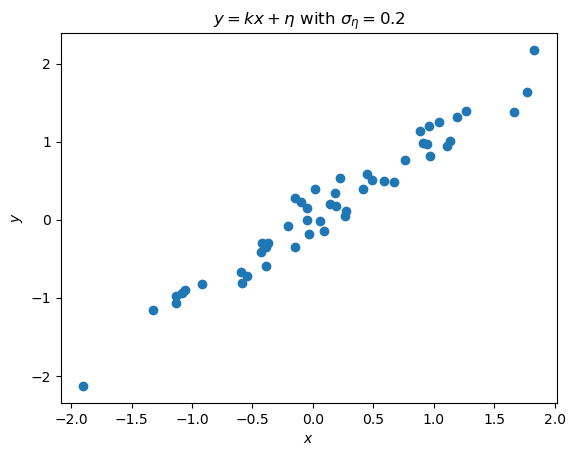

In [627]:
plot_xy(x, y, title="$y=kx+\eta$ with $\sigma_{\eta}=0.2$", xlabel="$x$", ylabel="$y$")

The plot above shows a noisy linear relationship as expected. We've condensed the above code down to the `plot_sample` function, we encourage you to play with different parameters for the noise distribution.

In [628]:
def plot_sample(num_points=50, mean_noise=0, sigma_noise=1, size=1):
    data = []
    for i in range(num_points):
        data.append(random_y_kx(mean_noise=mean_noise, sigma_noise=sigma_noise, size=size)) 
    _x = []
    _y = []
    for i in data:
        _x.append(i[0][0])
        _y.append(i[1][0])

    plot_xy(_x, _y)

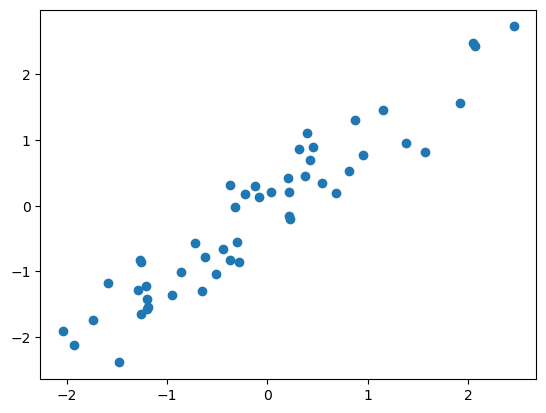

In [629]:
plot_sample(sigma_noise=0.5)

You should find that increasing the standard deviation parameter makes it more difficult to see the linear relationship between x and y - we can quantify this observation using a linear regression model.

## Modelling with Simulated Data

Now that we have our data we can create a model that will tell us some new information. In particular, we would like to know the optimal mathematical relationship that fits our data. Since our data appears to be linear, we can try a simple linear regression model.

Linear regression is often used to model data that is assumed to have a linear relationship. While very simple, linear regression is relatively good at finding a linear relationship when our data has random Gaussian noise. It fits the 'best' straight line to the data by minimising the sum of the squared distances between the data points and the line.

To create a linear regression model, we can use the `scikit-learn` library.

In [630]:
model = LinearRegression()

We can now evaluate our model using a score function. For simple linear regression, it is common to use the $R^2$ score function (also called the "coefficient of determination"). The $R^2$ score function tells us how predictable our `y` data is given `x` by considering the variance of the data distribution. In other words, it is the proportion of variance in `y` that is explained by the model, and is calculated using the equation:
$$ R^2 = 1 - \frac{RSS}{TSS} $$
in which RSS is the sum of squared residuals, and TSS is the total sum of squares. A value of 1 means that the data can be perfectly explained by a linear relationship, whereas a value of 0 means the data can in no way be explained by a linear relationship.

In [631]:
def linear_regression(x,y):
    x_arr = np.array(x)
    y_arr = np.array(y)

    model.fit(x_arr.reshape(-1, 1), y_arr.reshape(-1, 1))
    
    r_sq = model.score(x_arr.reshape(-1, 1), y_arr.reshape(-1, 1))
    print(f"Coefficient of determination: {r_sq}")
    print(f"Intercept: {model.intercept_[0]}")
    print(f"Slope: {model.coef_[0][0]}")

linear_regression(x,y)

Coefficient of determination: 0.954635388975013
Intercept: 0.03150794876660151
Slope: 0.9976250968710563


In this case, the model seems to fit really well to our synthetic data.

We can use simulated data to perform a 'virtual experiment' and test the effectiveness of our models in the presence of random errors, systematic errors, and anomalies when there is a known relationship that our data should follow. This leads into the next part of the notebook - testing a linear regression model with Coulomb's law!

## Modelling with Coulomb's Law Data

### Modelling the Force-Charge Relationship

By inspecting the equation describing Coulomb's law, we would expect to find a linear relationship between charge and force when the distance between two objects and the charge of one object are kept constant. The following code generates a synthetic 'force-charge' dataset, with a `sigma` paramater emulating random errors, for example due to the resolution of equipment, and a `systematic` parameter representing systematic errors, for example due to an instrument being calibrated incorrectly. For simplicity, the values for $r$ and $q_2$ are set to 1m and 1C respectively.

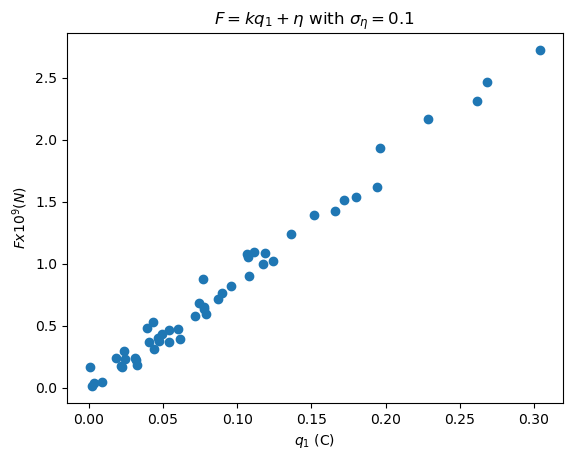

Coefficient of determination: 0.984241938487208
Intercept: -0.008970277219019218
Slope: 9.018419800662736


In [632]:
def force_charge(mean_x=0, sigma_x=0.1, mean_noise=0, sigma_noise=1, size=1, k=8.99, systematic_error=0):
    x = np.abs(np.random.normal(mean_x, sigma_x, size))
    noise = np.random.normal(mean_noise, sigma_noise, size)
    y = k * (x) + noise + systematic_error
    return x, y

systematic = 0  #Explore the effect of systematic errors by changing this value
sigma = 0.1     #Explore the effect of random errors by changing this value
charge_data = []
for i in range(50):
    charge_data.append(force_charge(sigma_noise=sigma, systematic_error = systematic))
    
charge_x = []
charge_y = []
for i in charge_data:
    charge_x.append(i[0][0])
    charge_y.append(i[1][0])

plot_xy(charge_x, charge_y, title="$F=kq_1+\eta$ with $\sigma_{\eta} = $"+ f"{sigma}", xlabel="$q_1$ (C)", ylabel="$F x10^{9} (N)$")

linear_regression(charge_x,charge_y)

From the known relationship, we expect the value of the intercept to be zero, as there is no force between two objects when one of them is not charged, and the value of the slope to be equal to the Coulomb constant.

We can test the robustness of our model in the presence of errors by varying the `systematic` and `sigma` parameters. You should find that introducing a systematic error will affect the `Intercept` output, whereas increasing the `sigma` parameter will impact the `Slope` output, as well as the `Coefficient of determination`, since a larger proportion of the variance in `F` will be due to the random error.

We can also study the effect of introducing anomalies into the dataset.

You are encouraged to add further anomalies into the array below and analyse the effectiveness of the model. You may find that a few extreme outliers can find can have a serious impact on the resulting values, suggesting that they should be cleaned from data before linear regression is used if they can be explained by human error - there will be more on **data cleaning** later in the course!

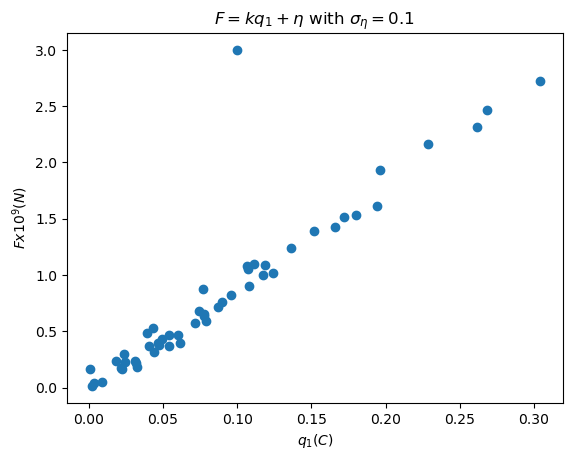

Coefficient of determination: 0.8221051960555352
Intercept: 0.02575240957300251
Slope: 9.090897754890088


In [633]:
anomalies = [(0.1,3)]
for anomaly in anomalies:
    charge_x.append(anomaly[0])
    charge_y.append(anomaly[1])

plot_xy(charge_x, charge_y, title="$F=kq_1+\eta$ with $\sigma_{\eta} = $"+ f"{sigma}", xlabel="$q_1 (C)$", ylabel="$F x10^{9} (N)$")

linear_regression(charge_x,charge_y)

### Modelling the Force-Distance Relationship

We can make this task more challenging by considering how we can use models to analyse the inverse square relationship between force and distance in Coulomb's law.

As before, we will develop a data generating function that we can use to create a synthetic dataset of force-distance values. In this case, the relationship we will be modeling is $$F = kr^{-2}$$
where $q_1$ and $q_2$ have been set to 1C for simplicity.

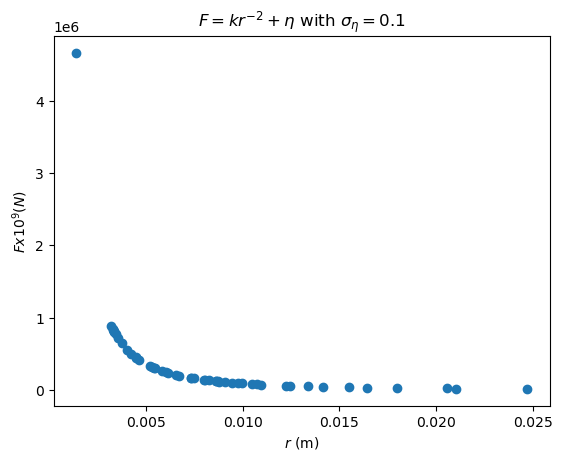

In [634]:
def force_distance(mean_x=0, sigma_x=0.01, mean_noise=0, sigma_noise=1, size=1, k=8.99, systematic_error=0):
    x = np.abs(np.random.normal(mean_x, sigma_x, size))
    noise = np.random.normal(mean_noise, sigma_noise, size)
    y = k * (x**(-2)) + noise + systematic_error
    return x, y

systematic = 0  #Explore the effect of systematic errors by changing this value
sigma = 0.1     #Explore the effect of random errors by changing this value
distance_data = []
for i in range(50):
    distance_data.append(force_distance(sigma_noise=sigma, systematic_error = systematic))
    
distance_x = []
distance_y = []
for i in distance_data:
    distance_x.append(i[0][0])
    distance_y.append(i[1][0])

plot_xy(distance_x, distance_y, title="$F=kr^{-2}+\eta$ with $\sigma_{\eta} = $"+ f"{sigma}", xlabel="$r $ (m)", ylabel="$F x10^{9} (N)$")


We can see that our data is clearly not linear - the force 'blows up' when separation approaches zero, so linear regression is not likely to be the best choice of a model. The options are as follows: either we find a different model that can handle non-linear data or we can do some data processing to make it better suited for a linear model. Here, we will take the latter approach.

In [635]:
x_transformed = np.c_[1 / np.square(distance_x)]

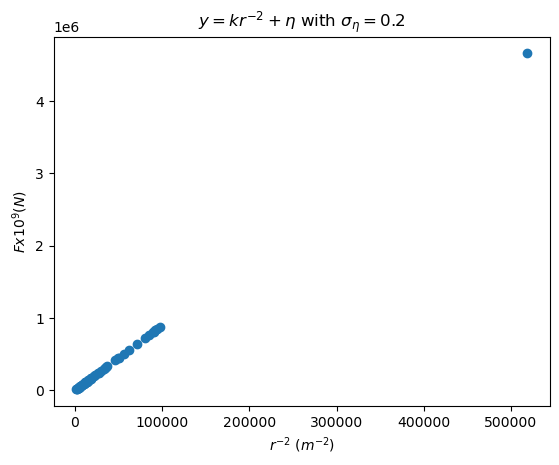

Coefficient of determination: 0.9999999999999786
Intercept: 0.016017222427763045
Slope: 8.990000081681274


In [636]:
plot_xy(x_transformed, distance_y, title="$y=kr^{-2}+\eta$ with $\sigma_{\eta}=0.2$", xlabel="$r^{-2}$ ($m^{-2}$)", ylabel="$F x10^{9} (N)$")

linear_regression(x_transformed,distance_y)

Here, we have inverted the generated `x` to linearise the relationship between `x` and `y`. In doing so, we made it possible to use the same linear regression model to analyse the relationship between `y` and `x`. Note that we used the knowledge of Coulomb's law to make this linearisation, so this would not be so easy if you didn't know the law that generated your data in real-world experiments, however, if the data is similar to that used in this notebook, an initial guess and subsequent trial and error can help you to a significantly better understanding of your data.

You are encouraged to explore how adding errors to the initial 'force-distance' dataset impacts the effectiveness of the model applied to the transformed coordinates.

If you wish to get an overview of the remaining topics in this course, click the button below.

[![Back to main website](../media/back4.png)](https://physdata.vercel.app/)
